## Ray Sampling

In [1]:
from pytorch3d.renderer import (
    PerspectiveCameras,
    look_at_view_transform
)

import numpy as np
import torch

In [2]:
def create_surround_cameras(radius, n_poses=20, up=(0.0, 1.0, 0.0), focal_length=1.0):
    cameras = []

    for theta in np.linspace(0, 2 * np.pi, n_poses + 1)[:-1]:

        if np.abs(up[1]) > 0:
            eye = [np.cos(theta + np.pi / 2) * radius, 0, -np.sin(theta + np.pi / 2) * radius]
        else:
            eye = [np.cos(theta + np.pi / 2) * radius, np.sin(theta + np.pi / 2) * radius, 2.0]

        R, T = look_at_view_transform(
            eye=(eye,),
            at=([0.0, 0.0, 0.0],),
            up=(up,),
        )

        cameras.append(
            PerspectiveCameras(
                focal_length=torch.tensor([focal_length])[None],
                principal_point=torch.tensor([0.0, 0.0])[None],
                R=R,
                T=T,
            )
        )
    
    return cameras

In [3]:
cameras = create_surround_cameras(3.0, n_poses=20)

### Get Pixels from Image

In [4]:
def get_pixels_from_image(image_size, camera):
    W, H = image_size[0], image_size[1]

    # TODO (1.3): Generate pixel coordinates from [0, W] in x and [0, H] in y
    x = torch.linspace(start=0, end=W, steps=W)
    y = torch.linspace(start=0, end=H, steps=H)

    # TODO (1.3): Convert to the range [-1, 1] in both x and y
    x = 1. - 2*x/W 
    y = 1. - 2*y/H 

    # Create grid of coordinates
    xy_grid = torch.cartesian_prod(x, y).flip(1)
    return xy_grid

In [5]:
image_size = [256, 256]
camera = cameras[0]
xy_grid = get_pixels_from_image(image_size, camera) # TODO (1.3): implement in ray_utils.py

In [6]:
xy_grid.shape

torch.Size([65536, 2])

##### Visualize Pixels

In [7]:
def vis_grid(xy_grid, image_size):
    xy_vis = (xy_grid + 1) / 2.001
    xy_vis = torch.cat([xy_vis, torch.zeros_like(xy_vis[..., :1])], -1)
    xy_vis = xy_vis.view(image_size[1], image_size[0], 3)
    xy_vis = np.array(xy_vis.detach().cpu())

    return xy_vis

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

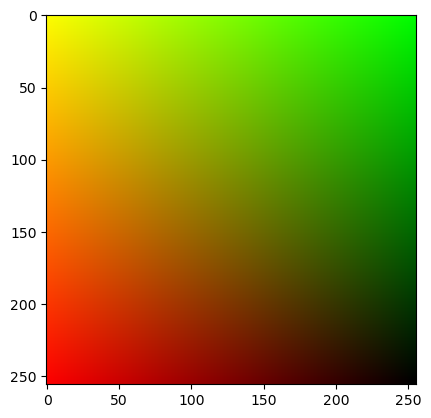

In [9]:
image_grid = vis_grid(xy_grid, image_size)
plt.imshow(np.uint8(image_grid * 255));


### Get Rays from Pixels

In [10]:
import torch.nn.functional as F
from pytorch3d.renderer import RayBundle

In [11]:
def get_rays_from_pixels(xy_grid, image_size=None, camera=None):
    # Map pixels to points on the image plane at Z=1
    xyz_grid = torch.cat((xy_grid, torch.ones(xy_grid.shape[0]).unsqueeze(-1)), dim=-1)

    # Use camera.unproject to get world space points on the image plane from NDC space points
    world_coords = camera.unproject_points(xyz_grid)

    # Get ray origins from camera center
    ray_origins = camera.get_camera_center().repeat(xyz_grid.shape[0], 1)

    # Get normalized ray directions
    ray_directions = F.normalize(world_coords - ray_origins)
    return RayBundle(
            origins=ray_origins,
            directions=ray_directions,
            lengths=None,
            xys=None)

###### Visualize Rays

In [12]:
def vis_rays(ray_bundle, image_size):
    rays = torch.abs(ray_bundle.directions)
    rays = rays.view(image_size[1], image_size[0], 3)
    rays = np.array(rays.detach().cpu())

    return rays

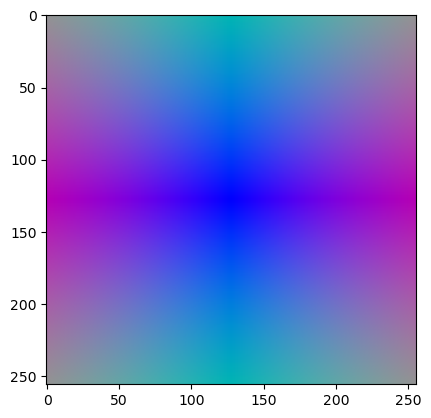

In [13]:
ray_bundle = get_rays_from_pixels(xy_grid, image_size, camera.to('cpu')) # TODO (1.3): implement in ray_utils.py

ray_grid = vis_rays(ray_bundle, image_size)
plt.imshow(np.uint8(ray_grid * 255));

## Point sampling

In [14]:
# Sampler which implements stratified (uniform) point sampling along rays

class StratifiedRaysampler(torch.nn.Module):
    def __init__(
        self,
        n_pts_per_ray=64, min_depth=0.0, max_depth=5.0
    ):
        super().__init__()

        self.n_pts_per_ray = n_pts_per_ray
        self.min_depth = min_depth
        self.max_depth = max_depth

    def forward(
        self,
        ray_bundle,
    ):
        # Compute z values for self.n_pts_per_ray points uniformly sampled between [near, far]
        z_values = torch.linspace(start=self.min_depth, end=self.max_depth, 
                                  steps=self.n_pts_per_ray)
        z_values = z_values[None, :, None].repeat(len(ray_bundle.origins), 1, 3)

        directions = ray_bundle.directions[:, None, :].repeat(1, self.n_pts_per_ray, 1)

        # Sample points from z values
        sample_points = ray_bundle.origins[:, None, :] + directions * z_values

        return ray_bundle._replace(lengths = z_values * torch.ones_like(sample_points[..., :1]),
                            xys = sample_points)
        


sampler_dict = {
    'stratified': StratifiedRaysampler
}

In [15]:
sampler = sampler_dict['stratified'](n_pts_per_ray=64, min_depth=0.0, max_depth=5.0)

In [16]:
ray_bundle = sampler(ray_bundle)       

##### Visualize sample points as point cloud

In [17]:
import pytorch3d
from pytorch3d.renderer import look_at_view_transform
from pytorch3d.renderer import OpenGLPerspectiveCameras
from pytorch3d.renderer import (
    AlphaCompositor,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    HardPhongShader,
)

def get_points_renderer(
    image_size=512, device=None, radius=0.01, background_color=(1, 1, 1)
):
    """
    Returns a Pytorch3D renderer for point clouds.

    Args:
        image_size (int): The rendered image size.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
        radius (float): The radius of the rendered point in NDC.
        background_color (tuple): The background color of the rendered image.
    
    Returns:
        PointsRenderer.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = PointsRasterizationSettings(image_size=image_size, radius=radius,)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(raster_settings=raster_settings),
        compositor=AlphaCompositor(background_color=background_color),
    )
    return renderer

In [18]:
def render_points(filename, points, image_size=256, color=[0.7, 0.7, 1], device=None):
    # The device tells us whether we are rendering with GPU or CPU. The rendering will
    # be *much* faster if you have a CUDA-enabled NVIDIA GPU. However, your code will
    # still run fine on a CPU.
    # The default is to run on CPU, so if you do not have a GPU, you do not need to
    # worry about specifying the device in all of these functions.
    if device is None:
        device = get_device()

    # Get the renderer.
    points_renderer = get_points_renderer(image_size=256,radius=0.01)

    # Get the vertices, faces, and textures.
    # vertices, faces = load_cow_mesh(cow_path)
    # vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    # faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    textures = torch.ones(points.size()).to(device)*0.5   # (1, N_v, 3)
    rgb = textures * torch.tensor(color).to(device)  # (1, N_v, 3)

    print('points.shape', points.shape, 'rgb.shape', rgb.shape)
    point_cloud = pytorch3d.structures.pointclouds.Pointclouds(
        points=points, features=rgb
    )

    R, T = look_at_view_transform(10.0, 10.0, 96)


    # Prepare the camera:
    cameras = OpenGLPerspectiveCameras(
        R=R,T=T, device=device
    )

    rend = points_renderer(point_cloud.extend(2), cameras=cameras)


    # Place a point light in front of the cow.
    # lights = pytorch3d.renderer.PointLights(location=[[0.0, 1.0, -2.0]], device=device)

    # rend = renderer(mesh, cameras=cameras, lights=lights)
    rend = rend.detach().cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
    plt.imshow(rend)
    plt.imsave(filename, rend)

    # The .cpu moves the tensor to GPU (if needed).
    return rend

In [19]:
xys = ray_bundle.xys
xys.shape

torch.Size([65536, 64, 3])

In [20]:
xys = xys.reshape(shape = (-1, 3))

print(xys.shape)

torch.Size([4194304, 3])


points.shape torch.Size([1, 4194304, 3]) rgb.shape torch.Size([1, 4194304, 3])


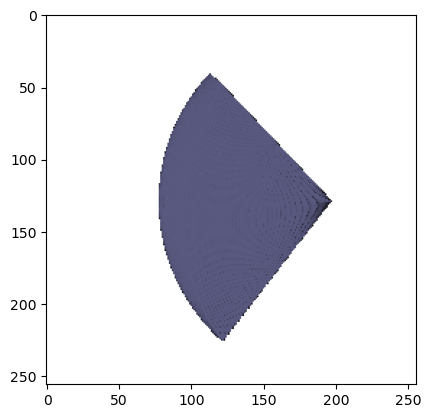

In [21]:
rend = render_points('pt_cloud.png', xys.unsqueeze(0).cuda(), device='cuda')